In [1]:
import sys
import glob
import serial
import numpy as np

def get_serial_ports():
    """ Lists serial port names

        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result

In [2]:
get_serial_ports()

['/dev/tty.Bluetooth-Incoming-Port',
 '/dev/tty.usbserial-01D5ED4C',
 '/dev/tty.SLAB_USBtoUART']

In [1]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#ser = serial.Serial('/dev/tty.usbserial-AH01L3MB', baudrate=115200)
ser = serial.Serial('/dev/tty.SLAB_USBtoUART', baudrate=500000)

ser.flushInput()

In [2]:
def get_sample():
    ser.write(b"R")
    s = b''
    done = False
    started = False
    while not done:
        current_char = ser.read()
        if current_char == b'$':
            break
        if started:
            s+=current_char

        if current_char == b'#':
            started = True
    return np.array(parse_hex_str(s))

def parse_hex_str(data):
    return [int(d, 16) for d in bytes.splitlines(data)]



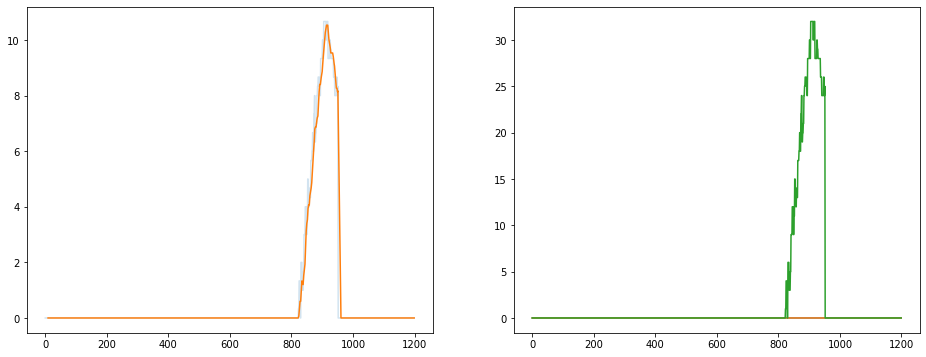

In [69]:
import time

def get_averaged_reading(n_samples, delay_sec):

    all_data = get_sample().reshape([1, -1])

    for i in range(max(n_samples-1, 0)):
        time.sleep(delay_sec)
        sample = get_sample()
        all_data = np.vstack([all_data, sample])
    return all_data

n_per_reading = 3 # number of subsamples for a reading
dt = 0.2 # delay in seconds between subsamples

data_mat = get_averaged_reading(n_per_reading, dt)
mean_sig = data_mat.mean(axis=0)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,6))
ax0.plot(mean_sig, alpha=0.2)
ax0.plot(pd.Series(mean_sig).rolling(10).mean())

ax1.plot(data_mat.T)